# Racing Line Calculation Worksheet

Inspired by the paper [Reinforcement Learning Using Neural Networks, with Applications to Motor Control
](https://www.remi-coulom.fr/Publications/Thesis.pdf), which is referenced by a number of machine learning articles, we calculate a race line around a simple race track.

In [1]:
import glob
import numpy as np
from shapely.geometry import Point, Polygon
from shapely.geometry.polygon import LinearRing, LineString
import pandas as pd
import matplotlib.pyplot as plt
import os.path

## Load the track to analyze

In [2]:
# Conveniently list available tracks to analyze
available_track_files = glob.glob("./tracks/**.npy")
available_track_names = list(map(lambda x: os.path.basename(x).split('.npy')[0], available_track_files))
available_track_names

['2022_april_open',
 '2022_april_pro',
 '2022_august_open',
 '2022_august_pro',
 '2022_july_open',
 '2022_july_pro',
 '2022_june_open',
 '2022_june_pro',
 '2022_march_open',
 '2022_march_pro',
 '2022_may_open',
 '2022_may_pro',
 '2022_october_open',
 '2022_october_pro',
 '2022_reinvent_champ',
 '2022_september_open',
 '2022_september_pro',
 '2022_summit_speedway',
 '2022_summit_speedway_mini',
 'Albert',
 'AmericasGeneratedInclStart',
 'Aragon',
 'arctic_open',
 'arctic_pro',
 'Austin',
 'AWS_track',
 'Belille',
 'Bowtie_track',
 'caecer_gp',
 'caecer_loop',
 'canada_race',
 'Canada_Training',
 'China_track',
 'dubai_open',
 'dubai_pro',
 'FS_June2020',
 'hamption_open',
 'hamption_pro',
 'H_track',
 'July_2020',
 'jyllandsringen_open',
 'jyllandsringen_pro',
 'LGSWide',
 'London_Loop_Train',
 'Mexico_track',
 'Monaco',
 'Monaco_building',
 'morgan_open',
 'morgan_pro',
 'New_York_Track',
 'Oval_track',
 'penbay_open',
 'penbay_pro',
 'red_star_open',
 'red_star_pro',
 'reInvent2019_tr

Is loop/ring?  True


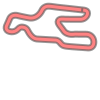

In [3]:
# Replace the name here with the track to analyze
TRACK_NAME = 'arctic_pro'

# Load the center, inner, outer waypoints
waypoints = np.load("./tracks/%s.npy" % TRACK_NAME)

# Convert to Shapely objects
center_line = waypoints[:,0:2]
inner_border = waypoints[:,2:4]
outer_border = waypoints[:,4:6]
l_center_line = LineString(center_line)
l_inner_border = LineString(inner_border)
l_outer_border = LineString(outer_border)
road_poly = Polygon(np.vstack((l_outer_border, np.flipud(l_inner_border))))
print("Is loop/ring? ", l_center_line.is_ring)
road_poly

# Display the original track waypoints

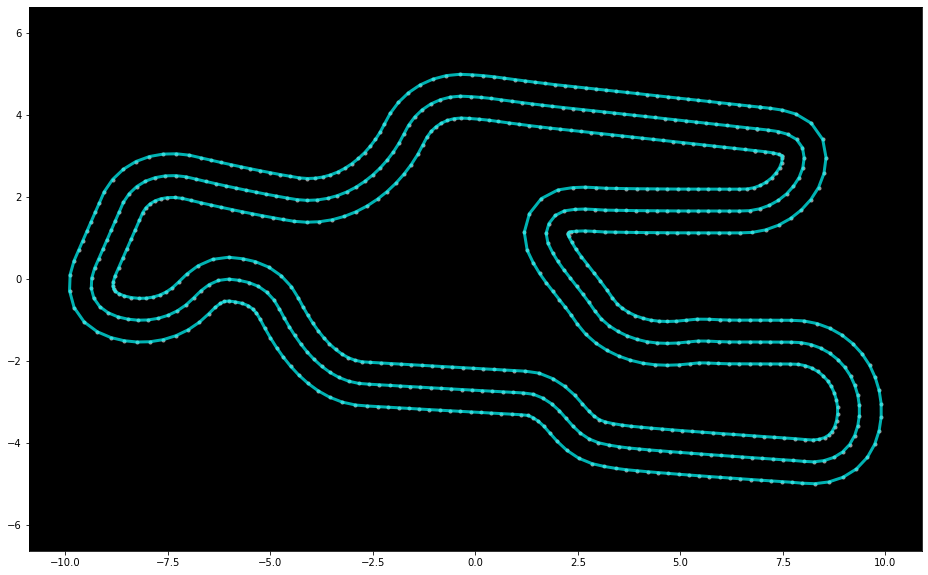

In [4]:
def plot_coords(ax, ob):                                                        
    x, y = ob.xy                                                                
    ax.plot(x, y, '.', color='#999999', zorder=1)                               
                                                                                
def plot_bounds(ax, ob):                                                        
    x, y = zip(*list((p.x, p.y) for p in ob.boundary))                          
    ax.plot(x, y, '.', color='#000000', zorder=1)                               
                                                                                
def plot_line(ax, ob):                                                          
    x, y = ob.xy                                                                
    ax.plot(x, y, color='cyan', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2)
                                                                                
def print_border(ax, waypoints, inner_border_waypoints, outer_border_waypoints):
    line = LineString(waypoints)                                                
    plot_coords(ax, line)                                                       
    plot_line(ax, line)                                                         
                                                                                
    line = LineString(inner_border_waypoints)                                   
    plot_coords(ax, line)                                                       
    plot_line(ax, line)                                                         
                                                                                
    line = LineString(outer_border_waypoints)                                   
    plot_coords(ax, line)                                                       
    plot_line(ax, line)     

fig = plt.figure(1, figsize=(16, 10))
ax = fig.add_subplot(111, facecolor='black')
plt.axis('equal')
print_border(ax, center_line, inner_border, outer_border)


In [5]:
# From https://github.com/e-koch/ewky_scripts/blob/master/curvature.py

# The MIT License (MIT)
#
# Copyright (c) 2014 Eric Koch
#
# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:

# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.

# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
# SOFTWARE.

def menger_curvature(pt1, pt2, pt3, atol=1e-3):

    vec21 = np.array([pt1[0]-pt2[0], pt1[1]-pt2[1]])
    vec23 = np.array([pt3[0]-pt2[0], pt3[1]-pt2[1]])

    norm21 = np.linalg.norm(vec21)
    norm23 = np.linalg.norm(vec23)

    theta = np.arccos(np.dot(vec21, vec23)/(norm21*norm23))
    if np.isclose(theta-np.pi, 0.0, atol=atol):
        theta = 0.0

    dist13 = np.linalg.norm(vec21-vec23)

    return 2*np.sin(theta) / dist13

In [6]:
import copy
from shapely.geometry import Point, Polygon
from shapely.geometry.polygon import LinearRing, LineString

# Number of times to iterate each new race line point
# keep this at 3-8 for best balance of performance and desired result
XI_ITERATIONS=4

# Number of times to scan the entire race track to iterate
# 500 will get a good start, 1500 will be closer to optimal result
LINE_ITERATIONS=1000

def improve_race_line(old_line, inner_border, outer_border):
    '''Use gradient descent, inspired by K1999, to find the racing line'''
    # start with the center line
    new_line = copy.deepcopy(old_line)
    ls_inner_border = Polygon(inner_border)
    ls_outer_border = Polygon(outer_border)
    for i in range(0,len(new_line)):
        xi = new_line[i]
        npoints = len(new_line)
        prevprev = (i - 2 + npoints) % npoints
        prev = (i - 1 + npoints) % npoints
        nexxt = (i + 1 + npoints) % npoints
        nexxtnexxt = (i + 2 + npoints) % npoints
        #print("%d: %d %d %d %d %d" % (npoints, prevprev, prev, i, nexxt, nexxtnexxt))
        ci = menger_curvature(new_line[prev], xi, new_line[nexxt])
        c1 = menger_curvature(new_line[prevprev], new_line[prev], xi)
        c2 = menger_curvature(xi, new_line[nexxt], new_line[nexxtnexxt])
        target_ci = (c1 + c2) / 2
        #print("i %d ci %f target_ci %f c1 %f c2 %f" % (i, ci, target_ci, c1, c2))

        # Calculate prospective new track position, start at half-way (curvature zero)
        xi_bound1 = copy.deepcopy(xi)
        xi_bound2 = ((new_line[nexxt][0] + new_line[prev][0]) / 2.0, (new_line[nexxt][1] + new_line[prev][1]) / 2.0)
        p_xi = copy.deepcopy(xi)
        for j in range(0,XI_ITERATIONS):
            p_ci = menger_curvature(new_line[prev], p_xi, new_line[nexxt])
            #print("i: {} iter {} p_ci {} p_xi {} b1 {} b2 {}".format(i,j,p_ci,p_xi,xi_bound1, xi_bound2))
            if np.isclose(p_ci, target_ci):
                break
            if p_ci < target_ci:
                # too flat, shrinking track too much
                xi_bound2 = copy.deepcopy(p_xi)
                new_p_xi = ((xi_bound1[0] + p_xi[0]) / 2.0, (xi_bound1[1] + p_xi[1]) / 2.0)
                if Point(new_p_xi).within(ls_inner_border) or not Point(new_p_xi).within(ls_outer_border):
                    xi_bound1 = copy.deepcopy(new_p_xi)
                else:
                    p_xi = new_p_xi
            else:
                # too curved, flatten it out
                xi_bound1 = copy.deepcopy(p_xi)
                new_p_xi = ((xi_bound2[0] + p_xi[0]) / 2.0, (xi_bound2[1] + p_xi[1]) / 2.0)

                # If iteration pushes the point beyond the border of the track,
                # just abandon the refinement at this point.  As adjacent
                # points are adjusted within the track the point should gradually
                # make its way to a new position.  A better way would be to use
                # a projection of the point on the border as the new bound.  Later.
                if Point(new_p_xi).within(ls_inner_border) or not Point(new_p_xi).within(ls_outer_border):
                    xi_bound2 = copy.deepcopy(new_p_xi)
                else:
                    p_xi = new_p_xi
        new_xi = p_xi
        # New point which has mid-curvature of prev and next points but may be outside of track
        #print((new_line[i], new_xi))
        new_line[i] = new_xi
    return new_line

## Calculate the race line!

In [7]:
print(len(center_line))
# start along centerline of track
race_line = copy.deepcopy(center_line[:-1])  # Use this for centerline being outer bound
for i in range(LINE_ITERATIONS):
    race_line = improve_race_line(race_line, inner_border, outer_border)
    if i % 20 == 0: print("Iteration %d" % i)

238
Iteration 0
Iteration 20
Iteration 40
Iteration 60
Iteration 80
Iteration 100
Iteration 120
Iteration 140
Iteration 160
Iteration 180
Iteration 200
Iteration 220
Iteration 240
Iteration 260
Iteration 280
Iteration 300
Iteration 320
Iteration 340
Iteration 360
Iteration 380
Iteration 400
Iteration 420
Iteration 440
Iteration 460
Iteration 480
Iteration 500
Iteration 520
Iteration 540
Iteration 560
Iteration 580
Iteration 600
Iteration 620
Iteration 640
Iteration 660
Iteration 680
Iteration 700
Iteration 720
Iteration 740
Iteration 760
Iteration 780
Iteration 800
Iteration 820
Iteration 840
Iteration 860
Iteration 880
Iteration 900
Iteration 920
Iteration 940
Iteration 960
Iteration 980


These should be the same:  ((238, 2), (238, 2))
Original centerline length: 59.52
New race line length: 52.15


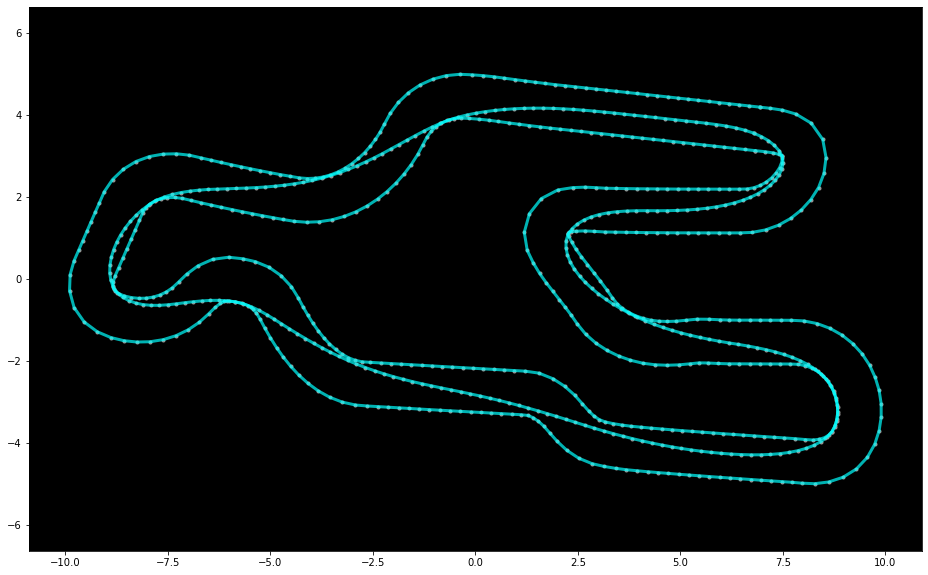

In [8]:
# need to put duplicate point race_line[0] at race_line[-1] to make a closed loops
loop_race_line = np.append(race_line, [race_line[0]], axis=0)

# These should be the same
print("These should be the same: ", (center_line.shape, loop_race_line.shape))
print("Original centerline length: %0.2f" % l_center_line.length)
print("New race line length: %0.2f" % LineString(loop_race_line).length)

fig = plt.figure(1, figsize=(16, 10))
ax = fig.add_subplot(111, facecolor='black')
plt.axis('equal')
print_border(ax, loop_race_line, inner_border, outer_border)

## Save the raceline as:

1. Binary numpy array for loading from a file
2. Text numpy array for pasting directly into a reward function

In [9]:
from datetime import datetime

now = datetime.now()
prefix = './racelines/%s-%d-%d-%s' % (TRACK_NAME, LINE_ITERATIONS, XI_ITERATIONS, now.strftime('%Y-%m-%d-%H%M%S'))
py_fname = prefix + '.py'
npy_fname = prefix + '.npy'
with open(py_fname, "w") as file:
    print("Writing python code to %s" % py_fname)
    file.write(np.array_repr(loop_race_line))
    
print("Writing numpy binary to %s" % npy_fname)
np.save(npy_fname, loop_race_line)

Writing python code to ./racelines/arctic_pro-1000-4-2023-03-08-090446.py
Writing numpy binary to ./racelines/arctic_pro-1000-4-2023-03-08-090446.npy


Adding extra extract with the boundary of the track

In [10]:


np.hstack((waypoints, loop_race_line))


array([[6.87774944, 3.66178751, 6.8198638 , ..., 4.19203711, 6.78572867,
        3.55837579],
       [6.62793398, 3.68915915, 6.56963015, ..., 4.21936321, 6.57618268,
        3.62802675],
       [6.37814403, 3.71672738, 6.31942797, ..., 4.24688578, 6.35225069,
        3.68473194],
       ...,
       [7.37607908, 3.59764493, 7.2640481 , ..., 4.11914682, 7.14643848,
        3.37528876],
       [7.12758899, 3.63461351, 7.05949211, ..., 4.16364908, 6.97710792,
        3.47436505],
       [6.87774944, 3.66178751, 6.8198638 , ..., 4.19203711, 6.78572867,
        3.55837579]])

In [11]:
from datetime import datetime

# Create a new np array 
# Include left boundary and raceline and right boundary

full_list = np.hstack((waypoints, loop_race_line))
np.set_printoptions(threshold=np.inf)
np.set_printoptions(suppress=True) 


now = datetime.now()
prefix = './racelines/full_%s-%d-%d-%s' % (TRACK_NAME, LINE_ITERATIONS, XI_ITERATIONS, now.strftime('%Y-%m-%d-%H%M%S'))
py_fname = prefix + '.py'
npy_fname = prefix + '.npy'
with open(py_fname, "w") as file:
    print("Writing python code to %s" % py_fname)
    #np.savetxt(file, full_list, delimiter=',', fmt='%1.8f')
    file.write(np.array_repr(full_list))    
print("Writing numpy binary to %s" % npy_fname)
np.save(npy_fname, full_list)

Writing python code to ./racelines/full_arctic_pro-1000-4-2023-03-08-090446.py
Writing numpy binary to ./racelines/full_arctic_pro-1000-4-2023-03-08-090446.npy


# Load and visualize a stored track file

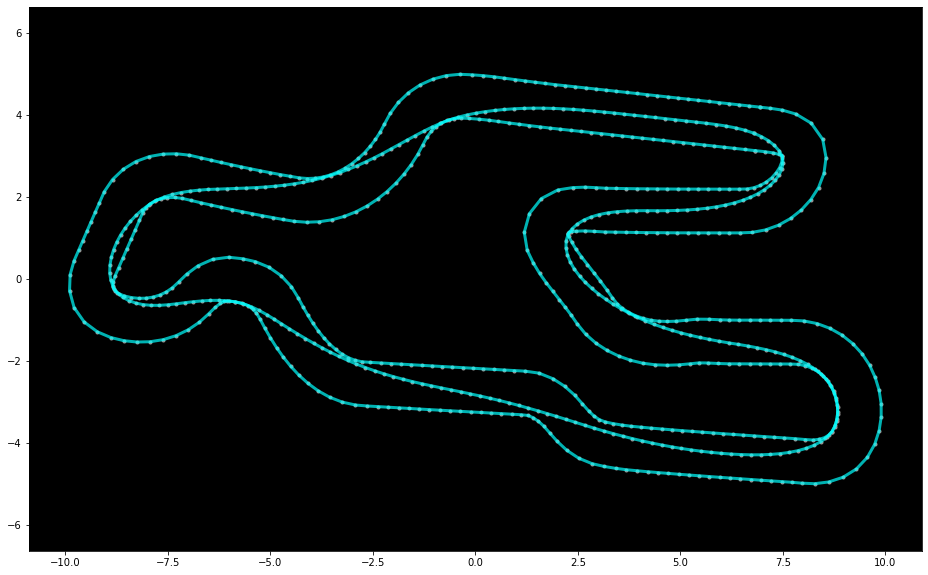

In [12]:
from numpy import array

fname = './racelines/arctic_pro-1000-4-2023-03-03-005235.py'
with open(fname, "r") as file:
    deserialized = eval(file.read())
deserialized
fig = plt.figure(1, figsize=(16, 10))
ax = fig.add_subplot(111, facecolor='black')
plt.axis('equal')
print_border(ax, deserialized, inner_border, outer_border)

### Test a reward file

In [13]:
%pip install ipywidgets

In [14]:

#sample dictionary with most of the needed params
def get_test_params():
    return {
        'x': 0.7,
        'y': 1.05,
        'heading': 160.0,
        'track_width': 0.45,
        'is_reversed': False,
        'steering_angle': 0.0,
        'speed': 1.0,
        'waypoints': [
            [0.75, -0.7],
            [1.0, 0.0],
            [0.7, 0.52],
            [0.58, 0.7],
            [0.48, 0.8],
            [0.15, 0.95],
            [-0.1, 1.0],
            [-0.7, 0.75],
            [-0.9, 0.25],
            [-0.9, -0.55],
        ]
    }



## Show the plot of the track and test the car location and orientations

- Move the sliders to change the location of the car.
- Change the is_reversed dictionary entry in the params definition above if you need to reverse the direction of the track
- Waypoints get replaced by the ones loaded for this track 
- Copy your reward function into the same directory as this notebook and then change `import example_reward1` to the name of your reward file.  So if you call the file `my_reward.py` change the line to `import my_reward as rf`

In [15]:
%matplotlib inline
from ipywidgets import interact
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from numpy import array
import example_reward1 as rf

fname = './racelines/arctic_pro-1000-4-2023-03-03-005235.py'
with open(fname, "r") as file:
    deserialized = eval(file.read())
deserialized

from matplotlib.offsetbox import OffsetImage, AnnotationBbox



def f(varX, varY, varHeading, varSteeringAngle, varSpeed):
    params = get_test_params()
    #add our waypoints to the sample params
    params["waypoints"] = waypoints
    
    fig = plt.figure(1, figsize=(16, 10))
    ax = fig.add_subplot(111, facecolor='black')
    plt.axis('equal')
    print_border(ax, deserialized, inner_border, outer_border)
    params["x"] = varX
    params["y"] = varY
    params["heading"] = varHeading
    params["steering_angle"] = varSteeringAngle
    params["speed"] = varSpeed 
    print("Reward at this location(%f, %f), steering angle %f, bearing %f and speed %f." 
           % (params["x"], params["y"], params["steering_angle"], params["heading"], params["speed"]))
    print("Reward %f" % rf.reward_function(params))
    t = ax.text(varX, varY, "Heading",
            ha="center", va="center", rotation=varHeading, size=10,
            bbox=dict(boxstyle="rarrow,pad=0.3",
                      fc="lightblue", ec="steelblue", lw=2))
    plt.show()

interact(f, varX = (-10.0,10.0), varY = (-10.0,10.0), varHeading = (-180,180), varSteeringAngle = (-60,60), varSpeed = (0.1,5.0))


interactive(children=(FloatSlider(value=0.0, description='varX', max=10.0, min=-10.0), FloatSlider(value=0.0, …

<function __main__.f(varX, varY, varHeading, varSteeringAngle, varSpeed)>